https://towardsdatascience.com/bert-for-measuring-text-similarity-eec91c6bf9e1


https://towardsdatascience.com/similarity-metrics-in-nlp-acc0777e234c 

https://www.youtube.com/watch?v=Ey81KfQ3PQU


Model semantic search: 'multi-qa-MiniLM-L6-cos-v1'

Model assymetric : 'msmarco-MiniLM-L-6-v3'

In [1]:
import sys
import os

# Add the 'Functions' directory to the Python path
sys.path.append(os.path.abspath('../../Functions'))


from connection.connection import *
from AlertP1.data_cleaning import *
from AlertP1.features import *
from analysis.step_analysis import *
from AlertP1.dummy_features import *
from Models.Logistic_regression import *
from Models.evaluation import *
from NLP.data_with_nlp import *
from BERT.bert import *
from pipeline import *

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import xgboost as xgb
# Import argsort
from numpy import argsort
import pandas as pd
# import pandasql as ps
import matplotlib.pyplot as plt

/home/gabrielabib/.conda/envs/nova/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
protocols = pd.read_csv('./BERT/protocols.csv')
protocols_acceptance = protocols[['Acceptance']]
protocols_refusal = protocols[['Refusal']]
protocols_acceptance.dropna(inplace=True)

In [3]:
# # 1. Data cleaning
lower_text(protocols_acceptance,'Acceptance', 'Acceptance')
lower_text(protocols_refusal,'Refusal', 'Refusal')
remove_stop_words(protocols_acceptance,'Acceptance', 'Acceptance')
remove_stop_words(protocols_refusal,'Refusal', 'Refusal')
spacy_lemmatizer(protocols_acceptance,'Acceptance', 'Acceptance')
spacy_lemmatizer(protocols_refusal,'Refusal', 'Refusal')

protocols_acceptance

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/gabrielabib/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/gabrielabib/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/gabrielabib/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/gabrielabib/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,Acceptance
0,cefaleia crónico refratária associar abuso med...
1,distúrbio movimento distúrbio equilíbrio quer ...
2,doença neuromuscular genético dor neuropático ...
3,distúrbio aprendizagem retardor psicomotor
4,síndromes demencial demência primário secundár...
5,esclerose múltiplo outro doença desmielinizant...


In [4]:
acceptance_list = protocols_acceptance['Acceptance'].tolist()
acceptance_list

['cefaleia crónico refratária associar abuso medicamentoso',
 'distúrbio movimento distúrbio equilíbrio quer frequente distonia doença parkinson parkinsonismo esclarecer tremor essencial difícil controle ataxias esclarecer coreia / balismos etc',
 'doença neuromuscular genético dor neuropático refratário parestesia recorrente e/ou progressivo paraplegia paresio esclerose lateral amiotrófico suspeito miopatia miastenia grave outro transtorno neuromuscular amiotrofia espinhal síndromes correlato polineuropatia outro transtorno sistema nervoso periférico snp doenço neurogenético',
 'distúrbio aprendizagem retardor psicomotor',
 'síndromes demencial demência primário secundário dúvida diagnósticar demência rapidamente progressivo',
 'esclerose múltiplo outro doença desmielinizante neuroimunológico']

In [5]:
[acceptance_list[0]]

['cefaleia crónico refratária associar abuso medicamentoso']

In [6]:
alertP1 = connection('credentials.txt')
data = pre_process(alertP1)


Tables: [('ConsultaUrgencia_doentespedidosconsultaNeurologia2012',), ('consultaneurologia2012',), ('consultaneurologia201216anon_true',), ('hgo_data_032023',)]
81


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/gabrielabib/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/gabrielabib/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
# alertP1_simplified = alertP1[['COD_REFERENCIA', 'Texto']]

In [8]:
# alertP1_simplified.info()

In [9]:
# lower_text(alertP1_simplified,'Texto', 'Texto')
# remove_stop_words(alertP1_simplified,'Texto', 'Texto_Stop_Words')
# spacy_lemmatizer(alertP1_simplified,'Texto_Stop_Words', 'text_lemmatized')
# alertP1_simplified

In [10]:
model_name = 'bert-base-nli-mean-tokens'

In [11]:
from sentence_transformers import SentenceTransformer

In [12]:
model = SentenceTransformer(model_name)

In [13]:
from sklearn.metrics.pairwise import cosine_similarity

referrals = data['clean_text'].tolist()


for index, protocol in enumerate(acceptance_list):

    sentences = [protocol] + referrals

    sentences_vectors = model.encode(sentences)

    results = cosine_similarity([sentences_vectors[0]], sentences_vectors[1:])

    column_name = 'acc_prot_' + str(index)

    data[column_name] = results[0]

    


In [14]:
# alertP1_simplified.describe()


## XGboost

In [15]:
def precision_at_k(y_true, y_pred, k):
    y_true = y_true.to_numpy()
    # Get the indices of the top k predictions
    top_k_indices = np.argsort(y_pred)[-k:]
    # Get the top k predictions
    top_k_predictions = y_true[top_k_indices]
    # Calculate precision@k
    precision = np.sum(top_k_predictions) / k
    return precision

In [16]:
def xgb_classifier(features, target):
    
    # split X and y into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2,random_state=16,shuffle=False)

    # X_train['before_accepted'] = X_train['before_accepted'].astype('category')
    # X_test['before_accepted'] = X_test['before_accepted'].astype('category')

    # Convert data into DMatrix format
    dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical = True)
    dtest = xgb.DMatrix(X_test, enable_categorical = True)

    # Set parameters for the XGBoost model
    param = {
        'max_depth': 3,
        'eta': 0.3,
        'objective': 'binary:logistic',
        'seed': 16
    }

    # Train the model
    num_round = 10
    bst = xgb.train(param, dtrain, num_round)

    # Make preictions on the train set
    y_pred_train = bst.predict(dtrain)
    # Make predictions on the test set
    y_pred_test = bst.predict(dtest)
    
    return y_pred_train, y_pred_test, bst.get_score(), X_train, X_test, y_train, y_test    

In [17]:
eliminate_cols=['ID_DOENTE','PROCESSO','COD_REFERENCIA','result','COD_PZ','COD_UNID_SAUDE_PROV','UNID_PROV','TIPO_UNID','COD_CTH_PRIOR','CTH_PRIOR','COD_MOTIVO_RECUSA','DES_MOTIVO_RECUSA','COD_ESPECIALIDADE','DES_ESPECIALIDADE','agrupadora','OUTRA_ENTIDADE','DATA_RECEPCAO','DATA_ENVIO','DATA_RETORNO','NUM_TAXA','ESTADO','DATA_MARCACAO','DATA_REALIZACAO','OBSERVACOES','Mês_entrada','Ano_entrada','trata data recusa','resume saída','mês_saida','ano_saida','Texto','clean_text']
X = data.drop(eliminate_cols,axis=1)# Features
y = data.result # Target variable
features=X.columns

y_pred_train, y_pred_test, model_score, X_train, X_test, y_train, y_test = xgb_classifier(X,y)

In [18]:
import pandas as pd
from sklearn.metrics import accuracy_score, recall_score, precision_score, precision_recall_curve, auc, confusion_matrix, cohen_kappa_score

def evaluate_thresholds(y_pred_train, y_train, y_pred_test, y_test, metrics = "test", k=211):
    #Precion@k
    def precision_at_k(y_true, y_pred, k):
        y_true = y_true.to_numpy()
        # Get the indices of the top k predictions
        top_k_indices = np.argsort(y_pred)[-k:]
        # Get the top k predictions
        top_k_predictions = y_true[top_k_indices]
        # Calculate precision@k
        precision = np.sum(top_k_predictions) / k
        return precision

    if metrics == "test":
        # Default threshold (0.5)
        default_threshold = 0.5
        default_y_pred_binary = (y_pred_test >= default_threshold).astype(int)
        default_accuracy = accuracy_score(y_test, default_y_pred_binary)
        default_recall = recall_score(y_test, default_y_pred_binary)
        default_precision = precision_score(y_test, default_y_pred_binary)
        default_precision_at_k = precision_at_k(y_test, default_y_pred_binary, k)
        
        # Define thresholds
    

        # Precision-Recall trade-off
        precision, recall, thresholds = precision_recall_curve(y_train, y_pred_train)
        f1_scores = 2 * precision * recall / (precision + recall)
        best_index = pd.Series(f1_scores).idxmax()
        pr_threshold = thresholds[best_index]
        pr_y_pred_binary = (y_pred_test >= pr_threshold).astype(int)
        pr_accuracy = accuracy_score(y_test, pr_y_pred_binary)
        pr_recall = recall_score(y_test, pr_y_pred_binary)
        pr_precision = precision_score(y_test, pr_y_pred_binary)
        pr_precision_at_k = precision_at_k(y_test, pr_y_pred_binary, k)
        
        thresholds = np.linspace(0, 1, 100)

        # Balanced Accuracy
        cms = [confusion_matrix(y_train, (y_pred_train >= t).astype(int)) for t in thresholds]
        sensitivity = [cm[1, 1] / (cm[1, 1] + cm[1, 0]) for cm in cms]
        specificity = [cm[0, 0] / (cm[0, 0] + cm[0, 1]) for cm in cms]
        balanced_accuracy = [(s + sp) / 2 for s, sp in zip(sensitivity, specificity)]
        ba_threshold = thresholds[np.argmax(balanced_accuracy)]
        ba_y_pred_binary = (y_pred_test >= ba_threshold).astype(int)
        ba_accuracy = accuracy_score(y_test, ba_y_pred_binary)
        ba_recall = recall_score(y_test, ba_y_pred_binary)
        ba_precision = precision_score(y_test, ba_y_pred_binary)
        ba_precision_at_k = precision_at_k(y_test, ba_y_pred_binary,k)
        
        # Cohen's Kappa
        kappas = [cohen_kappa_score(y_train, (y_pred_train >= t).astype(int)) for t in thresholds]
        kappa_threshold = thresholds[np.argmax(kappas)]
        kappa_y_pred_binary = (y_pred_test >= kappa_threshold).astype(int)
        kappa_kappa = cohen_kappa_score(y_test, kappa_y_pred_binary)
        kappa_accuracy = accuracy_score(y_test, kappa_y_pred_binary)
        kappa_recall = recall_score(y_test, kappa_y_pred_binary)
        kappa_precision = precision_score(y_test, kappa_y_pred_binary)
        kappa_precision_at_k = precision_at_k(y_test, kappa_y_pred_binary, k)

        # Limit to K
        len_train_k = int(len(y_pred_train)*0.65)
        limit_to_k_threshold = np.sort(y_pred_train)[-len_train_k]
        limit_to_k_y_pred_binary = (y_pred_test >= limit_to_k_threshold).astype(int)
        limit_to_k_accuracy = accuracy_score(y_test, limit_to_k_y_pred_binary)
        limit_to_k_recall = recall_score(y_test, limit_to_k_y_pred_binary)
        limit_to_k_precision = precision_score(y_test, limit_to_k_y_pred_binary)
        limit_to_k_precision_at_k = precision_at_k(y_test, limit_to_k_y_pred_binary, k)

    else:
        # Default threshold (0.5)
        default_threshold = 0.5
        default_y_pred_binary = (y_pred_train >= default_threshold).astype(int)
        default_accuracy = accuracy_score(y_train, default_y_pred_binary)
        default_recall = recall_score(y_train, default_y_pred_binary)
        default_precision = precision_score(y_train, default_y_pred_binary)
        default_precision_at_k = precision_at_k(y_train, default_y_pred_binary, k)
        
        # Define thresholds
    

        # Precision-Recall trade-off
        precision, recall, thresholds = precision_recall_curve(y_train, y_pred_train)
        f1_scores = 2 * precision * recall / (precision + recall)
        best_index = pd.Series(f1_scores).idxmax()
        pr_threshold = thresholds[best_index]
        pr_y_pred_binary = (y_pred_train >= pr_threshold).astype(int)
        pr_accuracy = accuracy_score(y_train, pr_y_pred_binary)
        pr_recall = recall_score(y_train, pr_y_pred_binary)
        pr_precision = precision_score(y_train, pr_y_pred_binary)
        pr_precision_at_k = precision_at_k(y_train, pr_y_pred_binary, k)
        
        thresholds = np.linspace(0, 1, 100)

        # Balanced Accuracy
        cms = [confusion_matrix(y_train, (y_pred_train >= t).astype(int)) for t in thresholds]
        sensitivity = [cm[1, 1] / (cm[1, 1] + cm[1, 0]) for cm in cms]
        specificity = [cm[0, 0] / (cm[0, 0] + cm[0, 1]) for cm in cms]
        balanced_accuracy = [(s + sp) / 2 for s, sp in zip(sensitivity, specificity)]
        ba_threshold = thresholds[np.argmax(balanced_accuracy)]
        ba_y_pred_binary = (y_pred_train >= ba_threshold).astype(int)
        ba_accuracy = accuracy_score(y_train, ba_y_pred_binary)
        ba_recall = recall_score(y_train, ba_y_pred_binary)
        ba_precision = precision_score(y_train, ba_y_pred_binary)
        ba_precision_at_k = precision_at_k(y_train, ba_y_pred_binary,k)
        
        # Cohen's Kappa
        kappas = [cohen_kappa_score(y_train, (y_pred_train >= t).astype(int)) for t in thresholds]
        kappa_threshold = thresholds[np.argmax(kappas)]
        kappa_y_pred_binary = (y_pred_train >= kappa_threshold).astype(int)
        kappa_kappa = cohen_kappa_score(y_train, kappa_y_pred_binary)
        kappa_accuracy = accuracy_score(y_train, kappa_y_pred_binary)
        kappa_recall = recall_score(y_train, kappa_y_pred_binary)
        kappa_precision = precision_score(y_train, kappa_y_pred_binary)
        kappa_precision_at_k = precision_at_k(y_train, kappa_y_pred_binary, k)

        # Limit to K
        len_train_k = int(len(y_pred_train)*0.65)
        limit_to_k_threshold = np.sort(y_pred_train)[-len_train_k]
        limit_to_k_y_pred_binary = (y_pred_train >= limit_to_k_threshold).astype(int)
        limit_to_k_accuracy = accuracy_score(y_train, limit_to_k_y_pred_binary)
        limit_to_k_recall = recall_score(y_train, limit_to_k_y_pred_binary)
        limit_to_k_precision = precision_score(y_train, limit_to_k_y_pred_binary)
        limit_to_k_precision_at_k = precision_at_k(y_train, limit_to_k_y_pred_binary, k)

    # Create output dataframe
    data = {
        'Analysis': ['Default', 'Precision-Recall trade-off', 'Balanced Accuracy', "Cohen's Kappa", 'Limit to K'],
        'Threshold': [round(default_threshold, 2), round(pr_threshold, 2), round(ba_threshold, 2), round(kappa_threshold, 2), round(limit_to_k_threshold, 2)],
        'Accuracy': [round(default_accuracy, 2), round(pr_accuracy, 2), round(ba_accuracy, 2), round(kappa_accuracy, 2), round(limit_to_k_accuracy, 2)],
        'Recall': [round(default_recall, 2), round(pr_recall, 2), round(ba_recall, 2), round(kappa_recall, 2), round(limit_to_k_recall, 2)],
        'Precision': [round(default_precision, 2), round(pr_precision, 2), round(ba_precision, 2), round(kappa_precision, 2), round(limit_to_k_precision, 2)],
        'Precision@211': [round(default_precision_at_k, 2), round(pr_precision_at_k, 2), round(ba_precision_at_k, 2), round(kappa_precision_at_k, 2), round(limit_to_k_precision_at_k, 2)]
    }
    
    df = pd.DataFrame(data)
    return df



In [19]:
evaluate_thresholds(y_pred_train,y_train,y_pred_test,y_test,metrics="train")

,Analysis,Threshold,Accuracy,Recall,Precision,Precision@211
0,Default,0.50,0.81,0.97,0.80,0.88
1,Precision-Recall trade-off,0.53,0.81,0.96,0.80,0.88
2,Balanced Accuracy,0.71,0.75,0.72,0.91,0.94
3,Cohen's Kappa,0.64,0.80,0.84,0.87,0.91
4,Limit to K,0.66,0.79,0.82,0.87,0.91


In [20]:
evaluate_thresholds(y_pred_train,y_train,y_pred_test,y_test,metrics="test")

,Analysis,Threshold,Accuracy,Recall,Precision,Precision@211
0,Default,0.50,0.67,0.96,0.67,0.69
1,Precision-Recall trade-off,0.53,0.68,0.95,0.68,0.70
2,Balanced Accuracy,0.71,0.68,0.69,0.79,0.75
3,Cohen's Kappa,0.64,0.72,0.83,0.77,0.76
4,Limit to K,0.66,0.72,0.82,0.77,0.77


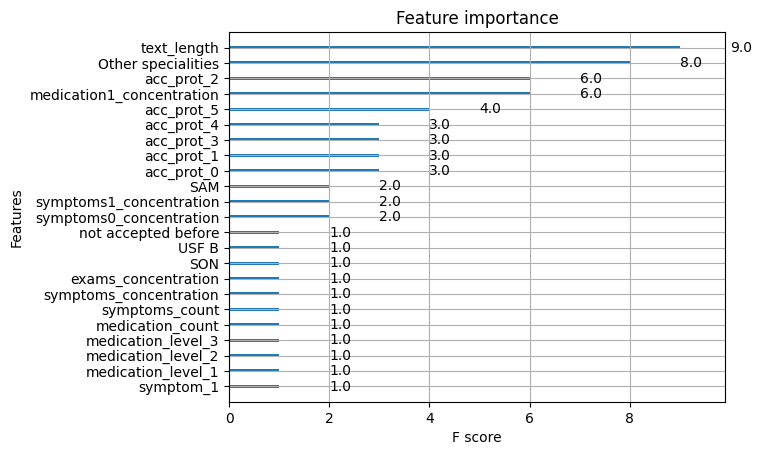

In [21]:
from xgboost import plot_importance

# Plot the feature importance scores
plot_importance(model_score)
plt.show()

## Rejection

In [22]:
rejection_list = protocols_refusal['Refusal'].tolist()
rejection_list

['nervosismo razão encaminhar neurologista exceto presente sinal sintoma lesão orgânico sistema nervoso central snc avaliar caso encaminhar saúde mental antes encaminhamento formal',
 'queixa somático explicação médico',
 'epilepsia controlar medicação dois ano monoterapia',
 'alteração sono insônio',
 'prevenção primário secundário doença cerebrovascular',
 'cefaleia primário típico enxaqueca tensional salvo episódica abuso medicamentoso',
 'paralisia facial periférico',
 'neurocisticercose calcificar lesão crônico inativo']

In [23]:
from sklearn.metrics.pairwise import cosine_similarity

referrals = data['clean_text'].tolist()


for index, protocol in enumerate(rejection_list):

    sentences = [protocol] + referrals

    sentences_vectors = model.encode(sentences)

    results = cosine_similarity([sentences_vectors[0]], sentences_vectors[1:])

    column_name = 'rej_prot_' + str(index)

    data[column_name] = results[0]


In [24]:
eliminate_cols=['ID_DOENTE','PROCESSO','COD_REFERENCIA','result','COD_PZ','COD_UNID_SAUDE_PROV','UNID_PROV','TIPO_UNID','COD_CTH_PRIOR','CTH_PRIOR','COD_MOTIVO_RECUSA','DES_MOTIVO_RECUSA','COD_ESPECIALIDADE','DES_ESPECIALIDADE','agrupadora','OUTRA_ENTIDADE','DATA_RECEPCAO','DATA_ENVIO','DATA_RETORNO','NUM_TAXA','ESTADO','DATA_MARCACAO','DATA_REALIZACAO','OBSERVACOES','Mês_entrada','Ano_entrada','trata data recusa','resume saída','mês_saida','ano_saida','Texto','clean_text']
X = data.drop(eliminate_cols,axis=1)# Features
y = data.result # Target variable
features=X.columns

y_pred_train, y_pred_test, model_score, X_train, X_test, y_train, y_test = xgb_classifier(X,y)

In [25]:
evaluate_thresholds(y_pred_train,y_train,y_pred_test,y_test,metrics="train")

,Analysis,Threshold,Accuracy,Recall,Precision,Precision@211
0,Default,0.50,0.81,0.98,0.79,0.87
1,Precision-Recall trade-off,0.57,0.82,0.96,0.81,0.88
2,Balanced Accuracy,0.66,0.79,0.80,0.88,0.91
3,Cohen's Kappa,0.65,0.79,0.82,0.88,0.91
4,Limit to K,0.64,0.79,0.84,0.86,0.91


In [26]:
evaluate_thresholds(y_pred_train,y_train,y_pred_test,y_test,metrics="test")

,Analysis,Threshold,Accuracy,Recall,Precision,Precision@211
0,Default,0.50,0.67,0.98,0.67,0.68
1,Precision-Recall trade-off,0.57,0.70,0.94,0.70,0.71
2,Balanced Accuracy,0.66,0.71,0.77,0.78,0.78
3,Cohen's Kappa,0.65,0.71,0.78,0.78,0.78
4,Limit to K,0.64,0.72,0.82,0.77,0.76


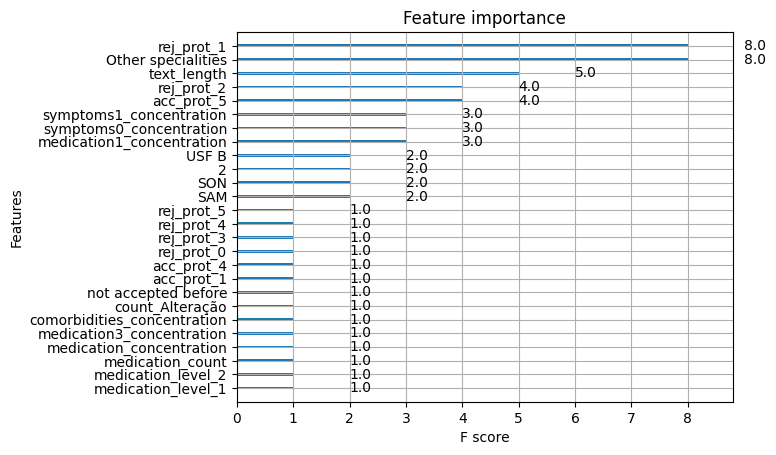

In [27]:
from xgboost import plot_importance

# Plot the feature importance scores
plot_importance(model_score)
plt.show()